In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

warnings.filterwarnings('ignore')

2026-02-17 17:55:42.185565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771350942.373380      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771350942.435502      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771350942.907654      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771350942.907712      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771350942.907716      24 computation_placer.cc:177] computation placer alr

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training', 
    shuffle=True
)


val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation', 
    shuffle=False
)


test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(f" Training images: {train_gen.samples}")
print(f" Validation images: {val_gen.samples}")
print(f" Testing images: {test_gen.samples}")

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
 Training images: 4173
 Validation images: 1043
 Testing images: 624


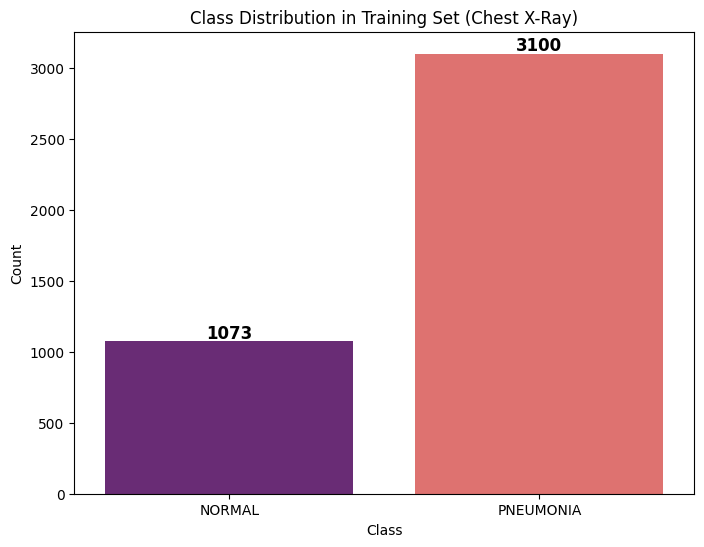

In [3]:

labels = train_gen.classes
class_names = list(train_gen.class_indices.keys())
counts = [np.sum(labels == i) for i in range(len(class_names))]


df_plot = pd.DataFrame({'Class': class_names, 'Count': counts})


plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Count', data=df_plot, palette='magma')


for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=12, fontweight='bold')

plt.title('Class Distribution in Training Set (Chest X-Ray)')
plt.show()

In [4]:
from sklearn.utils.class_weight import compute_class_weight

y_train = train_gen.classes

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


class_weight_dict = {i: weights[i] for i in range(len(weights))}

print("Computed Class Weights:")
for i, name in enumerate(class_names):
    print(f"   - {name}: {class_weight_dict[i]:.4f}")


Computed Class Weights:
   - NORMAL: 1.9445
   - PNEUMONIA: 0.6731


In [5]:
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False 


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


I0000 00:00:1771350964.288202      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,252,625 (23.85 MB)

 Trainable params: 330,753 (1.26 MB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('medical_pneumonia_model.keras', save_best_only=True)
]



In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    # class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1771350985.680902      84 service.cc:152] XLA service 0x7ea89c05ad80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771350985.680946      84 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771350988.988723      84 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/131 ━━━━━━━━━━━━━━━━━━━━ 1:13:10 34s/step - accuracy: 0.5938 - loss: 0.7287 - precision: 0.6552 - recall: 0.8636

I0000 00:00:1771351004.056838      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.6800 - loss: 0.7092 - precision: 0.7477 - recall: 0.8539 - val_accuracy: 0.7430 - val_loss: 0.6478 - val_precision: 0.7430 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 797ms/step - accuracy: 0.7048 - loss: 0.6480 - precision: 0.7703 - recall: 0.8685 - val_accuracy: 0.7162 - val_loss: 0.6751 - val_precision: 0.7731 - val_recall: 0.8748 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 802ms/step - accuracy: 0.6990 - loss: 0.6263 - precision: 0.7524 - recall: 0.8822 - val_accuracy: 0.7440 - val_loss: 0.6119 - val_precision: 0.7456 - val_recall: 0.9948 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 792ms/step - accuracy: 0.7256 - loss: 0.5583 - precision: 0.7620 - recall: 0.9174 - val_accuracy: 0.7363 - val_loss: 0.5732 - val_precision: 0.7515 - val_recall: 0.9639 - learning_rate: 0.0010
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 796ms/step - accu

Found 624 files belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 459ms/step
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
   Pneumonia       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



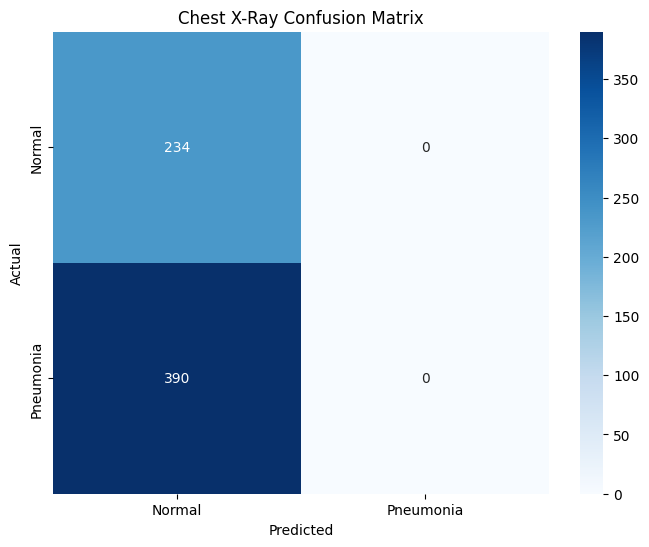

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


test_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False 
)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)


print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Chest X-Ray Confusion Matrix')
plt.show()

In [10]:
model.save('medical_pneumonia_model_final.keras')

In [11]:
from IPython.display import FileLink
FileLink(r'medical_pneumonia_model_final.keras')

/kaggle/working/medical_pneumonia_model_final.keras

# Cascade Model

In [12]:
import os
import pandas as pd
import numpy as np

def prepare_cascade_data(base_path):
    normal_dir = os.path.join(base_path, 'NORMAL')
    pneumo_dir = os.path.join(base_path, 'PNEUMONIA')
    
    
    normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if not f.startswith('.')]
    pneumo_files = [os.path.join(pneumo_dir, f) for f in os.listdir(pneumo_dir) if not f.startswith('.')]
    
    np.random.shuffle(pneumo_files)
    chunk_size = len(normal_files)
    cascades = []
    
    num_cascades = int(np.ceil(len(pneumo_files) / chunk_size))
    
    print(f"Total Normal: {len(normal_files)}")
    print(f"Total Pneumonia: {len(pneumo_files)}")
    print(f"Creating {num_cascades} balanced cascades...")

    for i in range(num_cascades):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(pneumo_files))
        
        
        current_pneumo_chunk = pneumo_files[start:end]
        
       
        chunk_files = normal_files + current_pneumo_chunk
        
       
        chunk_labels = ['NORMAL'] * len(normal_files) + ['PNEUMONIA'] * len(current_pneumo_chunk)
        
        # إنشاء الـ DataFrame
        df = pd.DataFrame({
            'filepath': chunk_files, 
            'label': chunk_labels
        })
        
        cascades.append(df.sample(frac=1).reset_index(drop=True))
        
    return cascades

# التشغيل الآن
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
cascade_dfs = prepare_cascade_data(train_path)

for i, df in enumerate(cascade_dfs):
    print(f"Cascade {i+1}: {len(df)} images ({df['label'].value_counts().to_dict()})")

Total Normal: 1341
Total Pneumonia: 3875
Creating 3 balanced cascades...
Cascade 1: 2682 images ({'NORMAL': 1341, 'PNEUMONIA': 1341})
Cascade 2: 2682 images ({'PNEUMONIA': 1341, 'NORMAL': 1341})
Cascade 3: 2534 images ({'NORMAL': 1341, 'PNEUMONIA': 1193})


In [13]:
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
cascade_dfs = prepare_cascade_data(train_path)

print(f"Created 3 Balanced Cascades. Each with {len(cascade_dfs[0])} images.")

Total Normal: 1341
Total Pneumonia: 3875
Creating 3 balanced cascades...
Created 3 Balanced Cascades. Each with 2682 images.


In [14]:
import tensorflow as tf


base_lr = 1e-4

all_histories = []

for i, df in enumerate(cascade_dfs):
    print(f"\nStarting Cascade Stage {i+1}/{len(cascade_dfs)}")
    
    current_lr = base_lr / (10**i) 
    model.optimizer.learning_rate = current_lr
    print(f"Learning Rate set to: {current_lr}")

    temp_train_gen = datagen.flow_from_dataframe(
        df,
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=True 
    )
    

    history = model.fit(
        temp_train_gen,
        epochs=10, 
        validation_data=val_gen,
        callbacks=callbacks 
    )
    
    all_histories.append(history.history)
    print(f"Finished Stage {i+1}")


Starting Cascade Stage 1/3
Learning Rate set to: 0.0001
Found 2682 validated image filenames belonging to 2 classes.
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5288 - loss: 0.7559 - precision: 0.5139 - recall: 0.9060 - val_accuracy: 0.7325 - val_loss: 0.5230 - val_precision: 0.7684 - val_recall: 0.9161 - learning_rate: 1.0000e-04
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 77s 923ms/step - accuracy: 0.6150 - loss: 0.6423 - precision: 0.6057 - recall: 0.6891 - val_accuracy: 0.7210 - val_loss: 0.5175 - val_precision: 0.7689 - val_recall: 0.8929 - learning_rate: 1.0000e-04
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 77s 917ms/step - accuracy: 0.6549 - loss: 0.6317 - precision: 0.6603 - recall: 0.6542 - val_accuracy: 0.7354 - val_loss: 0.5167 - val_precision: 0.7905 - val_recall: 0.8761 - learning_rate: 1.0000e-04
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 968ms/step - accuracy: 0.6449 - loss: 0.6308 - precision: 0.6532 - recall: 0.6178 - val_accuracy: 0.7440 - val_loss: 0.5183 - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 623ms/step


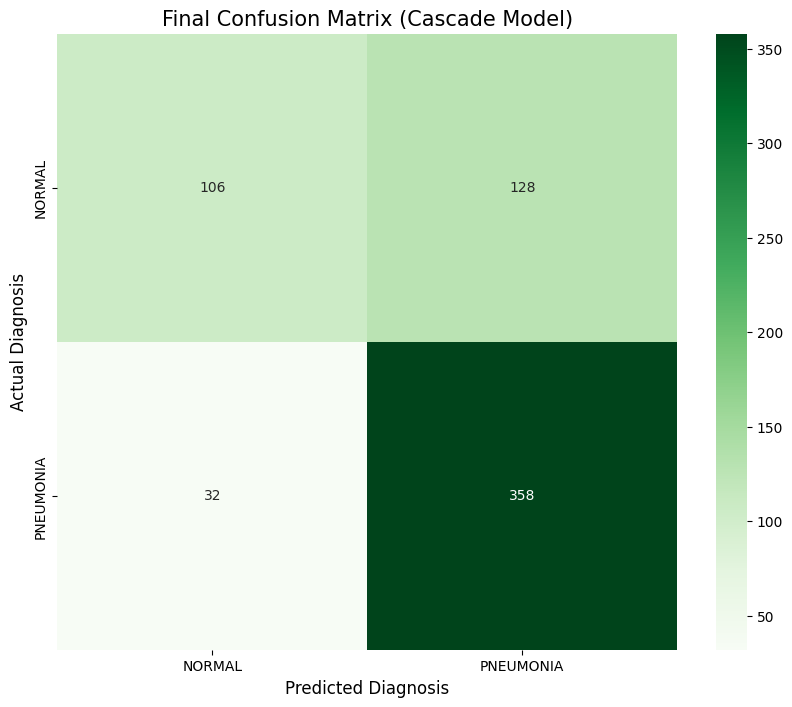


 Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.77      0.45      0.57       234
   PNEUMONIA       0.74      0.92      0.82       390

    accuracy                           0.74       624
   macro avg       0.75      0.69      0.69       624
weighted avg       0.75      0.74      0.72       624


🩺 Model Sensitivity (Ability to detect Pneumonia): 91.79%


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


test_gen.reset()
predictions = model.predict(test_gen, verbose=1)

y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys()) # ['NORMAL', 'PNEUMONIA']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_labels, 
            yticklabels=class_labels)

plt.title('Final Confusion Matrix (Cascade Model)', fontsize=15)
plt.xlabel('Predicted Diagnosis', fontsize=12)
plt.ylabel('Actual Diagnosis', fontsize=12)
plt.show()

print("\n Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print(f"\n🩺 Model Sensitivity (Ability to detect Pneumonia): {sensitivity*100:.2f}%")

In [16]:
model.save('chest_cascade_model_final.keras')

In [17]:
FileLink(r'chest_cascade_model_final.keras')

/kaggle/working/chest_cascade_model_final.keras

In [18]:
import json
import os



class_names = sorted(os.listdir(train_dir))


with open('chest_classes.json', 'w') as f:
    json.dump(class_names, f)

print(f"Saved classes: {class_names}")

Saved classes: ['NORMAL', 'PNEUMONIA']
